# Extracting and and saving image features using different models

In [1]:
import pandas as pd 
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm

#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
data_dir = '30_sample_2'
dir_path = os.path.join(r'data',data_dir)

In [3]:
##Load meta_data with image path from root
data_df = pd.read_csv(os.path.join(dir_path,'prepped_meta'))

In [4]:
#all image paths in this set
image_paths = data_df['image_path'].values

In [5]:
image_paths

array(['data\\30_sample_2\\images\\1707763.png',
       'data\\30_sample_2\\images\\1007627.png',
       'data\\30_sample_2\\images\\872979.png',
       'data\\30_sample_2\\images\\1801387.png',
       'data\\30_sample_2\\images\\1264264.png',
       'data\\30_sample_2\\images\\1459901.png',
       'data\\30_sample_2\\images\\732598.png',
       'data\\30_sample_2\\images\\6420.png',
       'data\\30_sample_2\\images\\1924442.png',
       'data\\30_sample_2\\images\\114689.png',
       'data\\30_sample_2\\images\\286124.png',
       'data\\30_sample_2\\images\\552391.png',
       'data\\30_sample_2\\images\\1286809.png',
       'data\\30_sample_2\\images\\951033.png',
       'data\\30_sample_2\\images\\724699.png',
       'data\\30_sample_2\\images\\1701516.png',
       'data\\30_sample_2\\images\\760268.png',
       'data\\30_sample_2\\images\\1978536.png',
       'data\\30_sample_2\\images\\1468315.png',
       'data\\30_sample_2\\images\\714058.png',
       'data\\30_sample_2\\image

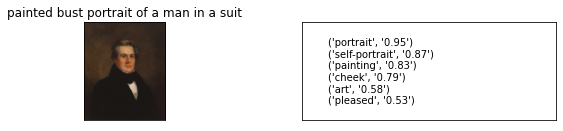

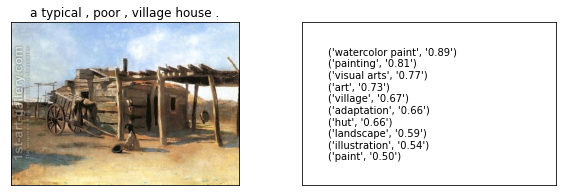

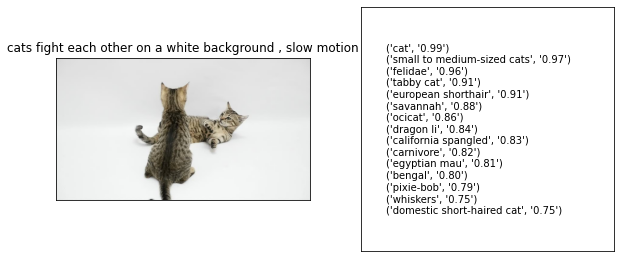

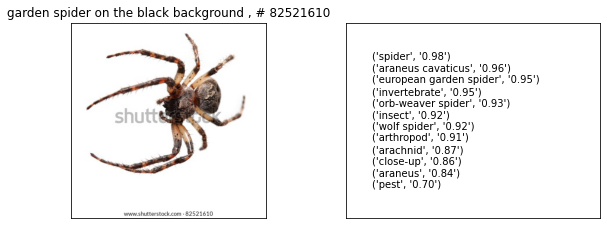

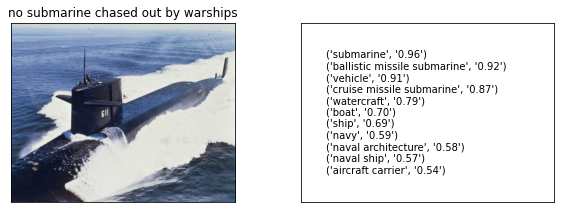

In [6]:
#display some images and captions to make sure the paths are correct
from utils import display_samples

display_samples(data_df)

## InceptionV3 pretrained model embeddings. 

Insipration from [this](https://www.tensorflow.org/tutorials/text/image_captioning) tutorial

In [7]:
#we define the pretrained model we are going to use. The weights are pretrained with image net and we only load evrything up to the last layer
def init_inception_v3_model():
    """
    Returns a pretrained inception V3 model without final layer to use to output embeddings
    """
    embeddings_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    input_layer = embeddings_model.input
    output_layer = embeddings_model.layers[-1].output
    inception_v3_feature_extractor = tf.keras.Model(input_layer,output_layer)
    return inception_v3_feature_extractor

In [8]:
#we need this helper function to put into the preprocessing pipeline
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    #this is the input size InceptionV3 takes in
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [9]:
#os.chdir(cwd)
#cwd = os.getcwd()
print(os.getcwd())

C:\Users\apra\Desktop\SPRING 2021\DS 4400\ML1_Final_Proj


In [10]:
def embed_images_with_inception_v3(image_paths, outpath):
    """
    embeds the images in the paths of the given dataframe in the given path into inception v3 embeddings
    and saves them in a directory with the given name.
    """
    #save current directory
    cwd = os.getcwd()
    #load and initialize the pretrained model
    
    inception_v3_feature_extractor = init_inception_v3_model()
    

    #we use this data pipeline from tensorflow
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    #this runs load_image on every image in the dataset in a batched manner
    #according to some research an RTX 20260 might work well with a batch size of 32, can be tuned furtherabs
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

    #change directory to directory we want to save embeddings in

    for image, image_path in tqdm(dataset):
        batch_embeddings = inception_v3_feature_extractor(image)
        #reshape batch embeddings to one embedding per image
        batch_embeddings = tf.reshape(batch_embeddings, 
                                     (batch_embeddings.shape[0], -1, batch_embeddings.shape[3]))

        for batch_embedding, path in zip(batch_embeddings,image_path):
            image_num = os.path.basename(path.numpy().decode("utf-8"))
            #save numpy embedding to current directory
            os.chdir(outpath)
            np.save(image_num,batch_embedding.numpy())
            os.chdir(cwd)
    #change back to cwd
    os.chdir(cwd)


In [ ]:
# #we will first attempt the pipeline on a few hundred samples to see if everything is fine
# num_samples = 100
# sample_image_paths = np.random.choice(image_paths, size=num_samples, replace = False )

In [11]:


embeddings_dir_name = 'inception_v3_embeddings_sample_100'
#create directory we want to store embeddings in and change to that directory
inception_v3_embeddings_directory = os.path.join(dir_path, embeddings_dir_name)
os.mkdir(inception_v3_embeddings_directory)

In [12]:
embed_images_with_inception_v3(image_paths, inception_v3_embeddings_directory)

87916544/87910968 [==============================] - 1s 0us/step


AttributeError: module 'tensorflow._api.v2.data' has no attribute 'AUTOTUNE'

### InceptionV3 model embeddings on 30k sample.

In [60]:
data_dir = '30k_sample'
dir_path = os.path.join(r'data',data_dir)
meta_data_path = os.path.join(dir_path, 'meta_data')
images_dir_path = os.path.join(dir_path, 'images')

In [61]:
meta_df = pd.read_csv(meta_data_path)

In [62]:
len(meta_df)

29968

In [63]:
meta_df['image_path'] = meta_df['index'].apply(lambda p: os.path.join(images_dir_path, str(p) + ".png"))

In [64]:
image_paths = meta_df['image_path'].values

In [67]:
#we will first attempt the pipeline on a few hundred samples to see if everything is fine
num_samples = 100
sample_image_paths = np.random.choice(image_paths, size=num_samples, replace = False )

In [68]:
embeddings_dir_name = 'inception_v3_embeddings'
#create directory we want to store embeddings in and change to that directory
inception_v3_embeddings_directory = os.path.join(dir_path, embeddings_dir_name)
os.mkdir(inception_v3_embeddings_directory)

In [70]:
embed_images_with_inception_v3(image_paths, inception_v3_embeddings_directory)

 68%|██████████████████████████████████████████████████████▎                         | 636/937 [02:31<01:11,  4.20it/s]


InvalidArgumentError: jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodePng}}]]

## Appendix: dropping rows in metadata for cells that do not exist and saving

In [58]:
#quick  code for dropping rows pertaining to images that do not exist
image_names = os.listdir(images_dir_path)
image_names = [i.split('.')[0] for i in image_names]

for idx,file in meta_df.iterrows():
    file = file['index']
    if not (str(file) in image_names):
        #meta_df.drop(labels=[idx], axis='index', inplace=True)
        print("dropped", idx,file)

In [59]:
meta_df.to_csv(meta_data_path,index=False)

### Errors encountered/fixes

more corrupt data (only get this error when running through model not during load/preprocess): https://github.com/tensorflow/tpu/issues/455. The code below is taken directly from this link

In [8]:
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        




In [ ]:
bads = []
images = ##NAME OF IMAGE FILES###
root_img = #DIRECRTIORY OF IMAGES###
for img in tqdm(images):
    image = os.path.join(root_img,img)
    image = JPEG(image) 
        try:
            image.decode()   
        except:
            bads.append(img)


# for name in bads:
#     os.remove(osp.join(root_img,name))